##### Liam Byrne
##### DATA 620 - Web Analytics
##### Fall - 2017

# Project 2

***

This Project will look at a two-mode network of personal donations to committees during the 2016 year. These committees are mainly political and include organizations such as political action committees (PACs), political interest groups and campaigns. The donors include individuals, companies and other varied groups. The data gathered from the [Federal Election Commission](http://classic.fec.gov/finance/disclosure/ftpdet.shtml) contains a wealth of information about donors, committees and elections. It would be interesting to use network analysis using some of this information, but in order to stay on track under the project metrics, we will solely be looking at the a subset of individuals donating to committees.

The main purpose behind this analysis is to isolate circles of big political movers and shakers and similar individuals who move in these circles. It is not surprising to see individuals such as George Soros and the Adelson Family running in these elite circles, but it is interesting to see names and organizations not familiar to the American mainstream.

Two networks will be analyzed:
+ A network of individuals who share donations to the same committee
+ A network of committees who share donors

First, we will first load the data of committees and personal contributions:

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite

# Committees
comm_url = "https://raw.githubusercontent.com/Liam-O/Data620/master/Wk7/cm.txt"
# Personal Contributions to Committees
pers_cont_url = "https://raw.githubusercontent.com/Liam-O/Data620/master/Wk7/2016_Contributions.csv"

comm_cols = ("CMTE_ID", "CMTE_NM", "TRES_NM", "CMTE_ST1", "CMTE_ST2",
             "CMTE_CITY", "CMTE_ST", "CMTE_ZIP", "CMTE_DSGN", "CMTE_TP	",
             "CMTE_PTY_AFFILIATION", "CMTE_FILING_FREQ	", "ORG_TP", "CONNECTED_ORG_NM", "CAND_ID")

comm = pd.read_csv(comm_url, sep = "|", header = None,
                        names = comm_cols)
pers_cont = pd.read_csv(pers_cont_url)

The personal contributions are each tied down to a committee. We will build a network of these contributions to committees making sure to aggregate duplicate instances of personal contributions to the same committee.

In [2]:
# Map committee names to df
pers_cont["COMM_NAME"] = pers_cont.CMTE_ID.map(
        pd.Series(comm.CMTE_NM.values, index = comm.CMTE_ID.values).to_dict())

pers_cont_copy = pers_cont.copy()

# Sum contributions to committees by each contributer to remove duplicate donations
# Resulting aggregate will be used to build graph
grouped = pers_cont.groupby(["CMTE_ID", "NAME"], as_index = False).agg({"TRANSACTION_AMT" : np.sum})

# Instantitate graph
pers_cont_g = nx.Graph()

# Build bipartite graph separating doners from committees
pers_cont_g.add_nodes_from(
        [pers_cont for cmte, pers_cont in grouped[["CMTE_ID", "NAME"]].values], bipartite = 0)
pers_cont_g.add_nodes_from(
        [cmte for cmte, pers_cont in grouped[["CMTE_ID", "NAME"]].values], bipartite = 1)

# Itteratively build edge list with total amount of money
# donated to specific committees
for source, target, att in grouped.values:
    pers_cont_g.add_edge(source, target, {"AMT": att})

The network has the following attributes:

In [3]:
print(nx.info(pers_cont_g))

Name: 
Type: Graph
Number of nodes: 3296
Number of edges: 3653
Average degree:   2.2166


This is a fairly large network and not much can be inferred from it. There are multiple sub-networks within due to there not being ties between everything. We will isolate the largest sub-network in the group and move forward with our binary projection of the network into donors and committees.

In [4]:
# Find the largest connected subgraph in the network
comm_donors_g = max(nx.connected_component_subgraphs(pers_cont_g), key=len)

# Instantitate bipartite sets to ready for projeciton
donor_nodes, comm_nodes = bipartite.sets(comm_donors_g)

# Build projected networks for donors and committees
# The edge weights will signify the times that the same committees were donated to.
donor_projected = bipartite.weighted_projected_graph(comm_donors_g, donor_nodes)
comm_projected = bipartite.weighted_projected_graph(comm_donors_g, comm_nodes)

donor_projected.name = "Projected Donors"
comm_projected.name = "Projected Committees"

print(nx.info(donor_projected) + "\n")
print(nx.info(comm_projected))

Name: Projected Donors
Type: Graph
Number of nodes: 2668
Number of edges: 324110
Average degree: 242.9610

Name: Projected Committees
Type: Graph
Number of nodes: 164
Number of edges: 861
Average degree:  10.5000


From the output above, it can be seen that these networks are still relatively large. We will use the island method on the respective networks' ```weights```, which correspond to the number of shared connections, to iterate through a rising cut-off point to stratify the respective relationships. Methods were used from the class text *Social Network Analysis for Startups by Alexander Kouznetsov and Maksim Tsvetovat* to achieve this.

In [5]:
def trim_edges(g, weight = 1):
    g2 = nx.Graph()
    for f, to, edata in g.edges(data = True):
        if edata["weight"] > weight:
            g2.add_edge(f, to, edata)
    return g2

def island_method(g, iterations = 5.0):
    weights = [edata["weight"] for f, to, edata in g.edges(data = True)]
    mn  = int(min(weights))
    mx  = int(max(weights))
    step = int((mx - mn)/iterations)

    return [[threshold, trim_edges(g, threshold)] for threshold in list(range(mn,mx,step))]

We will use the shared relationships between the donors and committees through the methods above to look at the stratified levels of the increasing movers and shakers in the respective networks.

In [6]:
from IPython.display import display

donor_islands = island_method(donor_projected)
comm_islands = island_method(comm_projected)

donor_strat = pd.DataFrame({"Weight_Cutoff": [i for (i, j) in donor_islands],
"Num_Nodes": [len(j) for (i, j) in donor_islands],
"Connected_Graphs": [nx.number_connected_components(j) for (i, j) in donor_islands]})
    
donor_strat = donor_strat[["Weight_Cutoff", "Num_Nodes", "Connected_Graphs"]]

comm_strat = pd.DataFrame({"Weight_Cutoff": [i for (i, j) in comm_islands],
"Num_Nodes": [len(j) for (i, j) in comm_islands],
"Connected_Graphs": [nx.number_connected_components(j) for (i, j) in comm_islands]})
    
comm_strat = comm_strat[["Weight_Cutoff", "Num_Nodes", "Connected_Graphs"]]

print("Stratified Donor Networks")
display(donor_strat)

print("\n\nStratified Committee Networks")
display(comm_strat)

Stratified Donor Networks


,Weight_Cutoff,Num_Nodes,Connected_Graphs
0,1,318,5
1,2,80,7
2,3,25,5
3,4,3,1
4,5,2,1




Stratified Committee Networks


,Weight_Cutoff,Num_Nodes,Connected_Graphs
0,1,70,2
1,14,9,2
2,27,2,1
3,40,2,1
4,53,2,1
5,66,2,1


We can see the ```weights``` thresholds for the committees are much larger. Let us look at the 2nd index of the Donor network and the 1st index of the Committee network to see the individuals/organizations who are in these key networks, i.e. the beginning of being in a small, elite group. We will show the combined donations and revenue for the donors and committees, respectively.

In [7]:
donor_totals = pers_cont_copy.groupby(["NAME"], as_index = False).agg({"TRANSACTION_AMT" : np.sum})

elite_donors = pd.DataFrame({"Name" : donor_islands[2][1].nodes(),
                            "Total_Donations" : [j for (i, j) in donor_totals.values if i in donor_islands[2][1].nodes()]})

comm_totals = pers_cont_copy.groupby(["CMTE_ID"], as_index = False).agg({"TRANSACTION_AMT" : np.sum})

elite_comms = pd.DataFrame({"Name" : comm_islands[1][1].nodes(),
                            "Total_Donations" : [j for (i, j) in comm_totals.values if i in comm_islands[1][1].nodes()]})
elite_comms = elite_comms.replace(
    {"Name": {id : name for id, name in comm[["CMTE_ID", "CMTE_NM"]].values if id in comm_islands[1][1].nodes()}})

print("Elite Donor Contributions")
display(elite_donors.sort_values(by = "Total_Donations", ascending= False))

print("\n\nElite Committee Revenue")
display(elite_comms.sort_values(by = "Total_Donations", ascending= False))

Elite Donor Contributions


,Name,Total_Donations
6,"SUSSMAN, S. DONALD",37266400
1,"STEPHENS, WARREN A.",27803400
21,"PRITZKER, JAY ROBERT",21838800
2,PRIORITIES USA ACTION,21503400
13,"GRIFFIN, KENNETH C.",16528000
23,"ADELSON, SHELDON",15172200
15,"MCINERNEY, THOMAS E.",12880673
11,"LAUFER, HENRY",11801500
20,"SIMONS, JAMES H.",11100200
16,"TUNA, CARI",10400000




Elite Committee Revenue


,Name,Total_Donations
3,REPUBLICAN NATIONAL COMMITTEE,179843296
7,HILLARY ACTION FUND,126235178
6,PRIORITIES USA ACTION,98818574
1,SENATE LEADERSHIP FUND,66448771
4,HILLARY VICTORY FUND,47636994
2,CONGRESSIONAL LEADERSHIP FUND,43105318
8,HOUSE MAJORITY PAC,25509811
5,SENATE MAJORITY PAC,17457800
0,TEAM RYAN,16632400


For these elite groups, it does not necessarily show us the top donors or the committees swimming in the most capital, but those that are the most active within groups. Namely, the donors sharing the respective sub-network are highly active in giving to the same causes and probably share the same ideals (note below for Donor Network). For the committees, the elite networks represent those who share groups of highly active donors.

Elite Donor Network


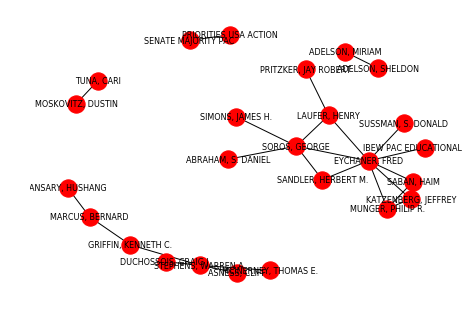

In [8]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

nx.draw(donor_islands[2][1], with_labels = True, font_size=8)
print("Elite Donor Network")
plt.show()

The island method is good way to stratify networks and note when there is an abrupt change in network. This abrupt change in network characteristics can isolate such things as high activity and like-mindedness. THe island method can be used with any quantifier (e.g. centrality measurements). When working with large networks, this could be an ideal way of sifting through non-relevant components of the network and highlight main points of interest.